In [1]:
# ================================================
# 🧹 1. Load CSV with Efficient Memory Usage
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import hashlib
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Use appropriate dtypes to reduce memory usage
dtypes = {
    'player_y': 'float32',
    'player_vel': 'float32',
    'cpu_y': 'float32',
    'ball_x': 'float32',
    'ball_y': 'float32',
    'ball_vel_x': 'float32',
    'ball_vel_y': 'float32',
    'reward': 'float32',
    'action': 'int8'
}

df = pd.read_csv('logs/pong_states_2025-05-15_20-17-57.csv', dtype=dtypes)

print(f"Loaded dataset with {len(df)} steps")
df.head()

Loaded dataset with 723728 steps


,episode,step,player_y,player_vel,cpu_y,ball_x,ball_y,ball_vel_x,ball_vel_y,reward,action
0,4501,0,24.000000,0.000000,24.004,31.968000,24.011843,-0.96,0.355285,0.000000e+00,2
1,4501,20,26.612345,0.189739,24.004,31.327999,24.248699,-0.96,0.355285,-1.868216e-07,1
2,4501,40,30.724733,0.212807,24.004,30.688000,24.485556,-0.96,0.355285,-2.124526e-07,1
3,4501,60,31.970043,-0.117560,24.004,30.048000,24.722414,-0.96,0.355285,-1.066227e-07,0
4,4501,80,32.002453,-0.073161,24.004,29.408001,24.959270,-0.96,0.355285,-5.729037e-08,0


In [3]:
state_cols = ["player_y", "player_vel", "cpu_y", "ball_x", "ball_y", "ball_vel_x", "ball_vel_y"]
unique_states = df[state_cols].drop_duplicates()
print("Unique states:", len(unique_states))
print("Total steps:", len(df))
print("State coverage ratio:", len(unique_states) / len(df))

Unique states: 723728
Total steps: 723728
State coverage ratio: 1.0


In [4]:
import numpy as np

state_cols = ["player_y", "player_vel", "cpu_y", "ball_x", "ball_y", "ball_vel_x", "ball_vel_y"]

# Define bin resolution (e.g., 50 bins per dimension)
n_bins = 50

# Discretize each column
df_discrete = df[state_cols].copy()
for col in state_cols:
    col_min = df_discrete[col].min()
    col_max = df_discrete[col].max()
    print(f"Values of {col}: min={col_min}, max={col_max}")
    # Normalize to [0, 1], then scale to bin indices
    df_discrete[col] = ((df_discrete[col] - col_min) / (col_max - col_min + 1e-8) * (n_bins - 1)).astype(int)

# Now count unique states after discretization
unique_states = df_discrete.drop_duplicates()
print("Discretized unique states:", len(unique_states))
print("Total steps:", len(df))
print("State coverage ratio:", len(unique_states) / len(df))


Values of player_y: min=3.5, max=44.5
Values of player_vel: min=-0.21599523723125458, max=0.21599653363227844
Values of cpu_y: min=3.4839999675750732, max=44.51599884033203
Values of ball_x: min=0.004800000227987766, max=63.98720169067383
Values of ball_y: min=1.0000035762786865, max=46.99991989135742
Values of ball_vel_x: min=-1.0080000162124634, max=0.9599999785423279
Values of ball_vel_y: min=-1.065068244934082, max=1.0758265256881714
Discretized unique states: 647139
Total steps: 723728
State coverage ratio: 0.8941743306877722


In [5]:
def collect_frame_hashes(folder_paths):
    frame_hashes = set()
    total_frames = 0
    for folder in folder_paths:
        for fname in sorted(os.listdir(folder)):
            if fname.endswith(('.png', '.jpg')):
                img_path = os.path.join(folder, fname)
                img = Image.open(img_path).convert('L')
                arr = np.array(img)
                h = hashlib.sha256(arr.tobytes()).hexdigest()
                frame_hashes.add(h)
                total_frames += 1
    return len(frame_hashes), total_frames

def compute_global_ufr(folder_paths):
    unique, total = collect_frame_hashes(folder_paths)
    print(f"Unique frames: {unique}, Total frames: {total}")
    return unique / total

In [6]:
folders = ["screens/images/damian_screens_01/", "screens/images/damian_screens_02/", "screens/images/damian_screens_03/"]
ufr = compute_global_ufr(folders)
print(f"Combined UFR: {ufr:.4f}")

Unique frames: 18039, Total frames: 27235
Combined UFR: 0.6623


In [7]:
import os
import hashlib
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

def hash_frame(img_path):
    img = Image.open(img_path).convert("RGB")
    return hashlib.sha256(img.tobytes()).hexdigest()

def collect_frames_by_episode(subfolders):
    episodes = defaultdict(list)
    
    for folder in subfolders:
        for fname in os.listdir(folder):
            if fname.endswith(".jpg") and "ep" in fname and "step" in fname:
                ep_part = fname.split("_")[0]  # 'epXXXX'
                ep_id = int(ep_part[2:])  # XXXX -> convert to int
                full_path = os.path.join(folder, fname)
                episodes[ep_id].append(full_path)
    
    return dict(sorted(episodes.items()))

In [8]:
def compute_cumulative_ufr(episodes):
    seen_hashes = set()
    total_frames_so_far = 0
    unique_frames_so_far = 0
    cum_ufrs = {}

    for ep_id, paths in sorted(episodes.items()):
        for path in paths:
            try:
                h = hash_frame(path)
                if h not in seen_hashes:
                    seen_hashes.add(h)
                    unique_frames_so_far += 1
                total_frames_so_far += 1
            except Exception as e:
                print(f"Error reading {path}: {e}")
        
        cum_ufrs[ep_id] = unique_frames_so_far / total_frames_so_far if total_frames_so_far else 0

    return cum_ufrs

def plot_cumulative_ufr(cum_ufrs):
    episodes = list(cum_ufrs.keys())
    ufr_values = list(cum_ufrs.values())

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, ufr_values, marker='o', color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Unique Frame Ratio")
    plt.title("Cumulative UFR Over Training Episodes")
    plt.grid(True)

    # Ensure only integer ticks on the x-axis
    plt.xticks(ticks=range(min(episodes), max(episodes)+1), rotation=45)

    plt.tight_layout()
    plt.show()

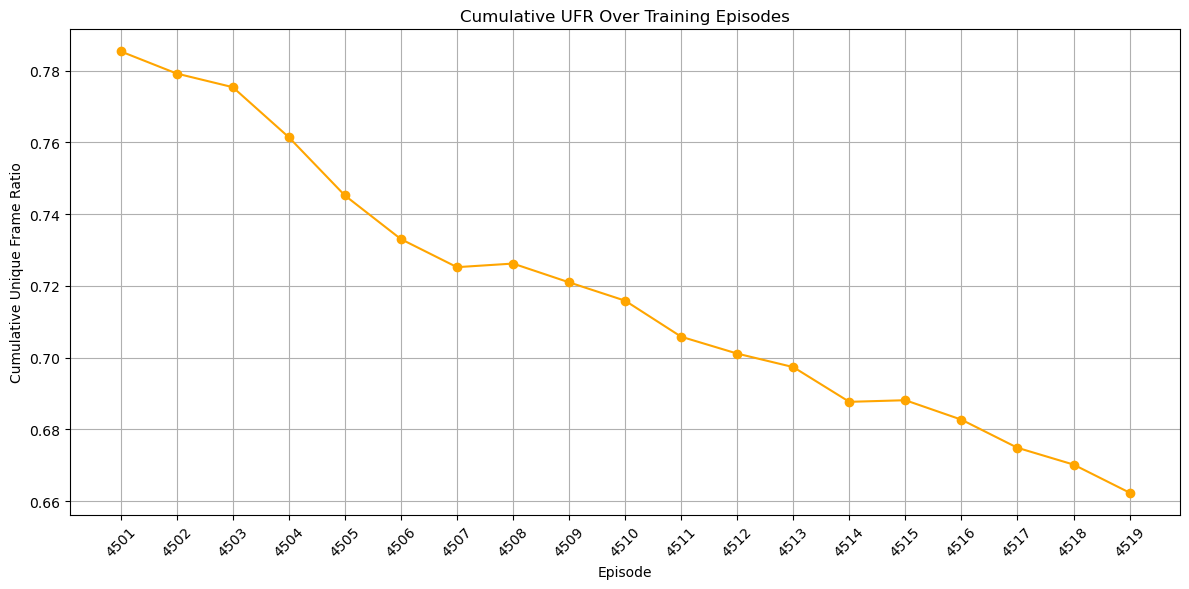

In [9]:
subfolders = ["screens/images/damian_screens_01/", "screens/images/damian_screens_02/", "screens/images/damian_screens_03/"]
episodes = collect_frames_by_episode(subfolders)
ep_ufrs = compute_cumulative_ufr(episodes)

# save data to disk
ufs_values = list(ep_ufrs.values())

np_episodes = np.array(list(ep_ufrs.keys()))
np_ufrs = np.array(list(ep_ufrs.values()))

np.save("ufr_damian_episodes.npy", np_episodes)
np.save("ufr_damian_values.npy", np_ufrs)

plot_cumulative_ufr(ep_ufrs)